In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score,confusion_matrix

C:\Users\user13\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('UNSW_NB15_training-set.csv')

In [3]:
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
print(df.shape)

(175341, 45)


In [5]:
# Handle missing values (fill with median for numerical columns)
df.fillna(df.median(numeric_only=True), inplace=True)

In [6]:
# Encode categorical variables (if any)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    # Check if the column has mixed types
    if df[col].apply(type).nunique() > 1:
        # Attempt to convert to numeric, coerce errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Impute NaNs with a suitable strategy (e.g., median)
        df[col].fillna(df[col].median(), inplace=True)

    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str)) # Convert the column to string type before encoding

In [7]:
# Drop unnecessary columns (if applicable)
columns_to_drop = ['id', 'timestamp']  # Example: Drop ID-based features
df = df.drop(columns=columns_to_drop, errors='ignore')

In [9]:
# Identify target variable (Replace 'Target' with actual target column name)
target_column = 'attack_cat'  # Modify based on dataset
X = df.drop(columns=[target_column])
y = df[target_column]

In [10]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
# Initialize Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=50,        # Reduce tree count
    max_depth=10,           # Prevent deep trees
    max_features='sqrt',    # Use subset of features
    min_samples_split=10,   # Prevent small splits
    random_state=42
)

In [12]:
# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=10,
                       n_estimators=50, random_state=42)

In [13]:
# Predictions
y_pred = rf_model.predict(X_test)

In [15]:
# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Accuracy: {accuracy*100:.2f}")

Optimized Accuracy: 86.39


In [16]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.19      0.32       499
           1       1.00      0.05      0.09       450
           2       0.70      0.01      0.03      2959
           3       0.61      0.96      0.75      8466
           4       0.88      0.89      0.89      4453
           5       1.00      0.98      0.99     10112
           6       1.00      1.00      1.00     13971
           7       0.92      0.65      0.76      2595
           8       0.82      0.25      0.38       300
           9       0.00      0.00      0.00        31

    accuracy                           0.86     43836
   macro avg       0.78      0.50      0.52     43836
weighted avg       0.88      0.86      0.83     43836



C:\Users\user13\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user13\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user13\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Cross-validation score
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print(f"Mean Cross-validation Accuracy: {np.mean(cv_scores):.2f}")

Mean Cross-validation Accuracy: 0.86


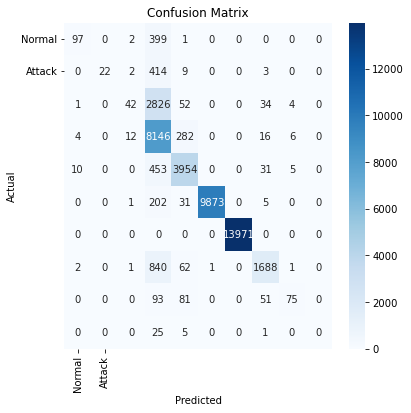

In [23]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

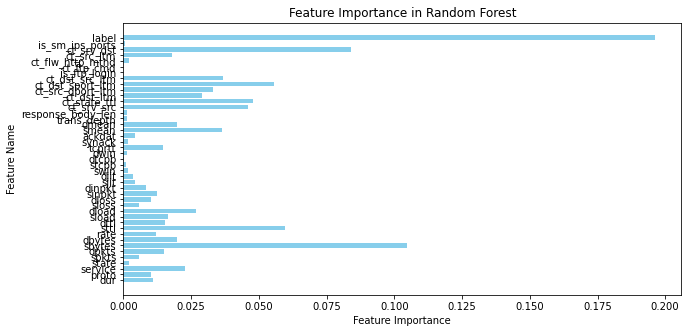

In [26]:
# Feature Importance Analysis
feature_importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feature_names, feature_importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest")
plt.show()

In [27]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_
best_y_pred = best_rf_model.predict(X_test)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


In [28]:
# Final Evaluation
final_accuracy = accuracy_score(y_test, best_y_pred)
print(f"Final Accuracy after Hyperparameter Tuning: {final_accuracy*100:.2f}")
print("Final Classification Report:\n", classification_report(y_test, best_y_pred))

Final Accuracy after Hyperparameter Tuning: 87.07
Final Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.23      0.36       499
           1       0.67      0.13      0.22       450
           2       0.33      0.14      0.20      2959
           3       0.64      0.90      0.75      8466
           4       0.94      0.89      0.92      4453
           5       1.00      0.98      0.99     10112
           6       1.00      1.00      1.00     13971
           7       0.92      0.75      0.82      2595
           8       0.72      0.65      0.68       300
           9       1.00      0.16      0.28        31

    accuracy                           0.87     43836
   macro avg       0.80      0.58      0.62     43836
weighted avg       0.87      0.87      0.86     43836

